In [66]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import h5py as h5
import h5py
from pathlib import Path
import seaborn as sns

## figure settings

In [67]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = '.SF Camera'


# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False


## df management

In [68]:
## LOADING THE MF HDF5 File 

filename='118_M_.doric'
folder = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/raw'
h5file = os.path.join(folder, filename)

## LOADING ANYMAZE FILE FOR TTL

TTL_an=pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/am/118_epm_am.csv')
# # patch bug for anmyze that detect mouse in both location when on edges between middle and open 
TTL_an.loc[(TTL_an['In Open Arms'] == 1) & (TTL_an['In middle'] == 1), 'In Open Arms'] = 0

pd.DataFrame(TTL_an)

## LOADING ANYMAZE POSITION FILE 

ampos=pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/ampos/118_epm_ampos.csv')
pd.DataFrame(ampos)

# Extract ID, sex and stage of experiment

base_name = os.path.basename(filename)
name_parts = base_name.split('_')
mouse_id = name_parts[0]
sex = name_parts[1]



with h5py.File(h5file, 'r') as f:
    # Find the channel signal from DORIC file
    folder = f['DataAcquisition']['EPConsole']['Signals']['Series0001']
    
    # Get time
    raw_time = folder['AIN01xAOUT01-LockIn']['Time']
    

    # Get signal
    values_gcamp = folder['AIN01xAOUT01-LockIn']['Values']
    values_iso = folder['AIN01xAOUT02-LockIn']['Values']
    values_rcamp = folder['AIN02xAOUT03-LockIn']['Values']

    #Get TLL 
    raw_dio_time = folder['DigitalIO']['Time']
    raw_TTL_wn = folder['DigitalIO']['DIO02']
    raw_TTL_tone = folder['DigitalIO']['DIO03']


    #Read the data 
    raw_time = raw_time[:]
    values_gcamp = values_gcamp[:]
    values_iso =  values_iso[:]
    values_rcamp = values_rcamp[:]
    raw_TTL_wn = raw_TTL_wn[:]
    raw_TTL_tone = raw_TTL_tone[:]
    raw_dio_time = raw_dio_time[:]

    #Sanity check for the win
    print("Raw Time (first 5):", raw_time[:5])
    print("Values gcamp (first 5):", values_gcamp[:5])
    print("values rcamp (first 5)", values_rcamp[:5])
    print("Values iso (first 5):", values_iso[:5])
    print("raw dio time (first 5)", raw_dio_time[:5])
    print("TTL_wn:", raw_TTL_wn[:5])
    print(len(values_gcamp))
    print(len(raw_TTL_tone))


Raw Time (first 5): [0.09105125 0.10765125 0.12425125 0.14085125 0.15745125]
Values gcamp (first 5): [0.11583914 0.11542316 0.11496426 0.11480724 0.1148893 ]
values rcamp (first 5) [3.49709838e-05 9.21362968e-05 6.93638885e-05 8.19535055e-05
 7.23398193e-05]
Values iso (first 5): [0.1005778  0.10043596 0.10032958 0.10028366 0.10025192]
raw dio time (first 5) [0.016267 0.032868 0.049467 0.066068 0.082668]
TTL_wn: [0. 0. 0. 0. 0.]
36147
36159


Average Sampling Interval: 0.01659999997233442 seconds
Sampling Frequency: 60.24096395581935 Hz
duration:, 600.023599 seconds
Average Sampling Interval after resampling: 0.016672390422754292 seconds
Sampling Frequency after resampling: 59.97940155211404 Hz
(36002,)
(36002,)
(36002,)
600.11465025
600.239067


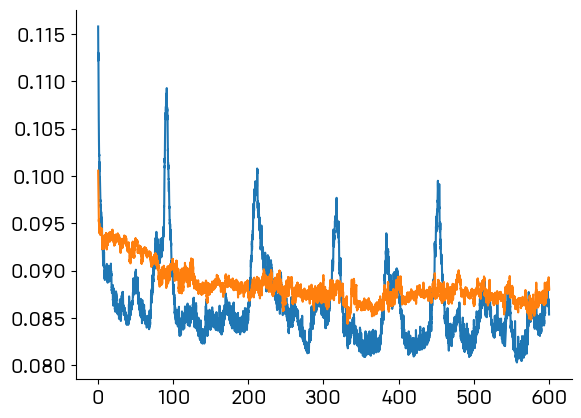

In [69]:
#RESAMPLING 
##Check the sampling 

# Calculate the differences between consecutive time points
time_differences = np.diff(raw_time)
average_sampling_interval = np.mean(time_differences)

# Calculate the sampling frequency
sampling_frequency = 1 / average_sampling_interval

print(f"Average Sampling Interval: {average_sampling_interval} seconds")
print(f"Sampling Frequency: {sampling_frequency} Hz")


### RESAMPLING 
duration = raw_time[-1] - raw_time[0]

new_sampling_rate = 60  # Hz
num_samples_resampled = int(duration * new_sampling_rate) + 1 ##Integer because can't be a fraction

# Resample gcamp + iso + TTL 
resampled_gcamp, time = resample(values_gcamp, num_samples_resampled, t=raw_time)
resampled_rcamp, time = resample(values_rcamp, num_samples_resampled, t=raw_time)
resampled_iso, time = resample(values_iso, num_samples_resampled, t=raw_time)
resampled_TTL_wn, time = resample(raw_TTL_wn, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE
resampled_TTL_tone, time = resample(raw_TTL_tone, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE

print(f"duration:, {duration} seconds")

## Sanity check for the win 
time_differences_resampled = np.diff(time)
average_sampling_interval_resampled = np.mean(time_differences_resampled)
sampling_frequency_resampled = 1 / average_sampling_interval_resampled

print(f"Average Sampling Interval after resampling: {average_sampling_interval_resampled} seconds")
print(f"Sampling Frequency after resampling: {sampling_frequency_resampled} Hz")
print(resampled_gcamp.shape)
print(resampled_rcamp.shape)
print(resampled_TTL_wn.shape)
print(raw_time[-1])
print(raw_dio_time[-1])

plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

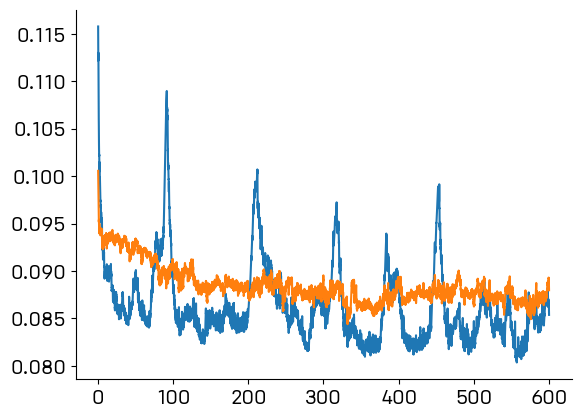

In [70]:
###Removing artifacts 

import numpy as np
from scipy.interpolate import interp1d

def remove_artifacts_and_interpolate(signal, time, threshold=0.0005, time_window=0.5):
    # Create a copy of the original signal
    cleaned_signal = signal.copy()

    # Define the sliding window size based on the time window
    window_size = np.sum(time <= time_window)

    # Iterate through the signal using a sliding window
    for i in range(len(cleaned_signal) - window_size):
        # Calculate the difference in signal within the window
        window_diff = cleaned_signal[i + window_size] - cleaned_signal[i]

        # If the difference exceeds the threshold, mark it as NaN
        if window_diff > threshold:
            cleaned_signal[i:i + window_size] = np.nan

    # Interpolate the NaN values
    nan_indices = np.isnan(cleaned_signal)
    interpolator = interp1d(time[~nan_indices], cleaned_signal[~nan_indices], kind='linear', fill_value='extrapolate')
    cleaned_signal[nan_indices] = interpolator(time[nan_indices])

    return cleaned_signal

# Apply the function to both 'resampled_gcamp' and 'resampled_iso'
resampled_gcamp = remove_artifacts_and_interpolate(resampled_gcamp, time)
resampled_iso = remove_artifacts_and_interpolate(resampled_iso, time)
resampled_rcamp = remove_artifacts_and_interpolate(resampled_rcamp, time)

# 'resampled_gcamp' and 'resampled_iso' now contain the cleaned signals


plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

In [71]:
####ABBERRANCE DETECTION : WHEN SIGNAL FUCKS UP - PATCHCORD gets detached

# Calculate the first derivative of the signal
signal_diff = np.diff(resampled_gcamp, prepend=resampled_gcamp[0])

# Set a threshold for detecting large jumps in the signal
threshold = np.std(signal_diff) * 20  # Adjust the factor as needed

# Identify the indices where the signal changes significantly
power_change_indices = np.where(np.abs(signal_diff) > threshold)[0]

print("Detected power change points at indices:", power_change_indices)

Detected power change points at indices: []


Signal successfully scaled across segments!


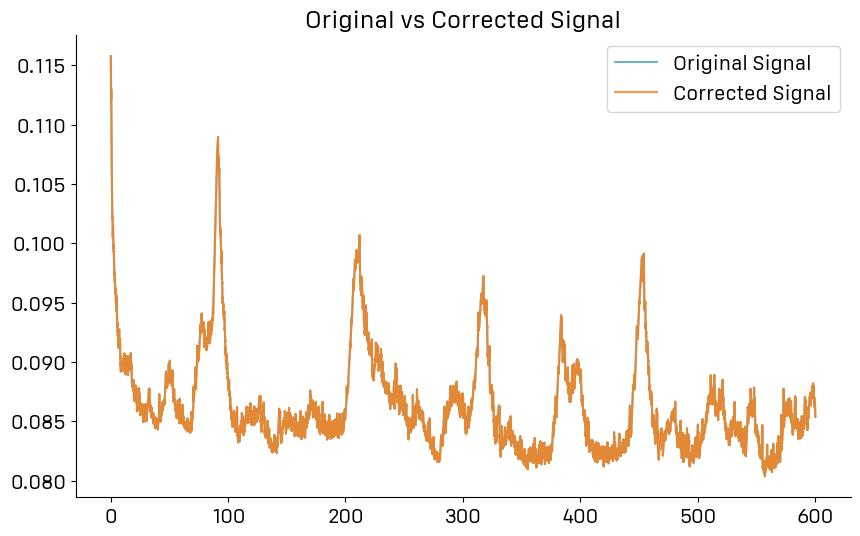

36002

In [72]:
#CORRECT THE ABBERATION

# Your resampled_gcamp signal and detected power change indices
# resampled_gcamp is your signal array
# power_change_indices contains the indices where signal changes (detected earlier)
# Include the start and end of the signal in the indices
power_change_indices = np.concatenate(([0], power_change_indices, [len(resampled_gcamp)]))

# Initialize an array to store the corrected signal
corrected_signal = np.copy(resampled_gcamp)

# Scale each segment based on the mean of the first segment
base_mean = np.mean(resampled_gcamp[power_change_indices[0]:power_change_indices[1]])

# Loop over each segment and scale them
for i in range(len(power_change_indices) - 1):
    start_idx = power_change_indices[i]
    end_idx = power_change_indices[i + 1]

    # Calculate the mean of the current segment
    segment_mean = np.mean(resampled_gcamp[start_idx:end_idx])

    # Compute the scaling factor
    scaling_factor = base_mean / segment_mean

    # Scale the segment
    corrected_signal[start_idx:end_idx] *= scaling_factor

# Now corrected_signal contains the adjusted signal
print("Signal successfully scaled across segments!")

plt.figure(figsize=(10,6))
plt.plot(time, resampled_gcamp, label='Original Signal', alpha=0.6)
plt.plot(time, corrected_signal, label='Corrected Signal', alpha=0.8)
plt.legend()
plt.title('Original vs Corrected Signal')
plt.show()

len(resampled_gcamp)
# len(corrected_signal)


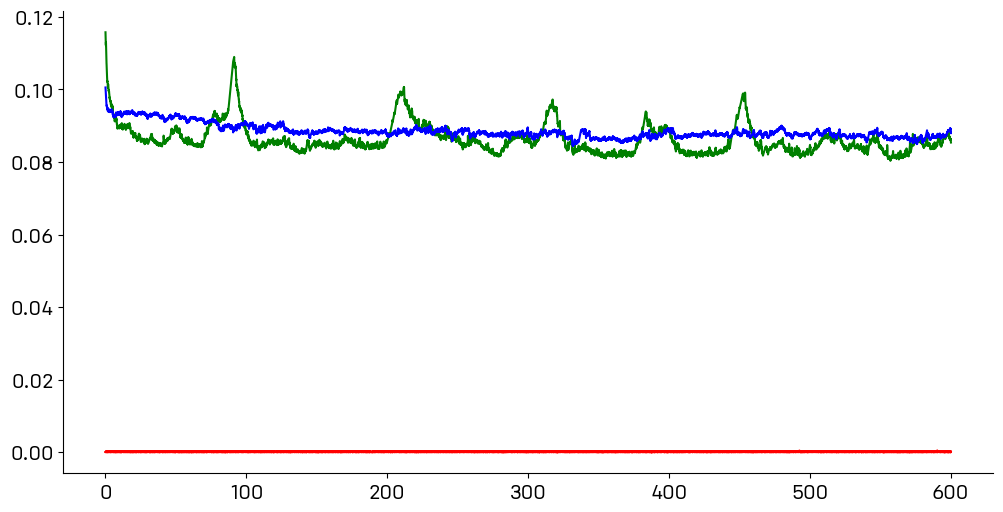

In [73]:

##RAW SIGNAL PLOT

# fig,ax1=plt.subplots(figsize=(12,6))  # create a plot to allow for dual y-axes plotting
# plot1=ax1.plot(time, resampled_gcamp, 'g', label='gcamp') 
# ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
# plot2=ax2.plot(time, resampled_iso, 'r', label='isosbestic') 
# # Labels
# lines = plot1 + plot2
# labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels) 

# ax1.set_ylim(0.3, 0.8)
# ax2.set_ylim(0.3, 0.8)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time, resampled_gcamp, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, resampled_iso, color='b')
plt.plot(time, resampled_rcamp, color='r')

In [74]:
# ##mouse fuck ups - find the epoch, delete it from both time, signal, and behavior files

# fustart=320
# fustop=370

# fstarti=fustart*60
# fstopi=fustop*60
# print(resampled_gcamp.shape, fstarti, fstopi)
# resampled_gcamp = np.delete(resampled_gcamp, np.arange(fstarti, fstopi))
# time=np.delete(time, np.arange(fstarti, fstopi))
# resampled_iso=np.delete(resampled_iso, np.arange(fstarti, fstopi))
# resampled_rcamp=np.delete(resampled_rcamp, np.arange(fstarti, fstopi))


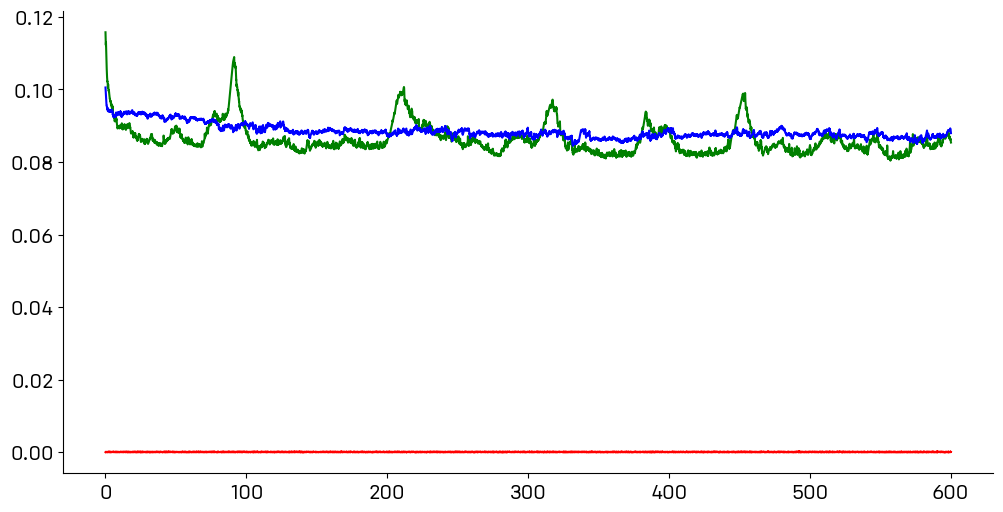

In [75]:
## NOISE CORRECTION 
sampling_rate = 60

b,a = butter(2, 10, btype='low', fs=sampling_rate)
gcamp_denoised = filtfilt(b,a, resampled_gcamp)
iso_denoised = filtfilt(b,a, resampled_iso)
rcamp_denoised = filtfilt(b, a, resampled_rcamp)


##NOISE CORRECTION  PLOT
plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_denoised, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, iso_denoised, color='b')
plt.plot(time, rcamp_denoised, color='r')
#ax2.set_ylim(0.6, 1.2)

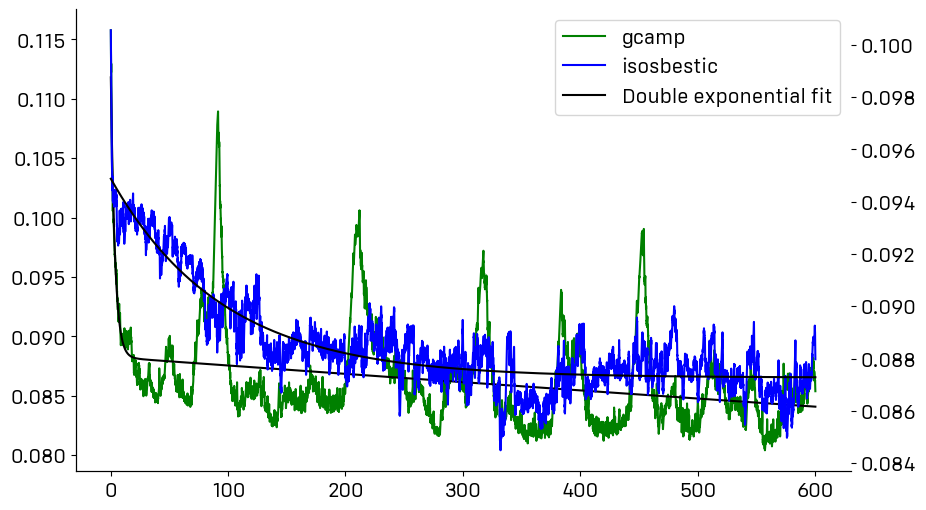

In [76]:
## PHOTOBLEACHING CORRECTION -> Maybe fit only on baseline periods and apply it to everything? 
#Using double exponential fit  

def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):

    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

## Fitting exp to signal 
#Gcamp
max_sig = np.max(gcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
gcamp_params, parm_cov = curve_fit(double_exponential, time, gcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares optimization
gcamp_expfit = double_exponential(time, *gcamp_params)

#Isosbestic
max_sig = np.max(iso_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
iso_params, parm_cov = curve_fit(double_exponential, time, iso_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
iso_expfit = double_exponential(time, *iso_params)

#Rcamp
max_sig = np.max(rcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
rcamp_params, parm_cov = curve_fit(double_exponential, time, rcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
rcamp_expfit = double_exponential(time, *rcamp_params)

##PLOTS 

fig,ax1=plt.subplots(figsize=(10,6))  

plot1=ax1.plot(time, gcamp_denoised, 'g', label='gcamp')
plot3=ax1.plot(time, gcamp_expfit, color='k', linewidth=1.5, label='Double exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time, iso_denoised, color='b', label='isosbestic') 
plot4=ax2.plot(time, iso_expfit,color='k', linewidth=1.5) 

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels); 


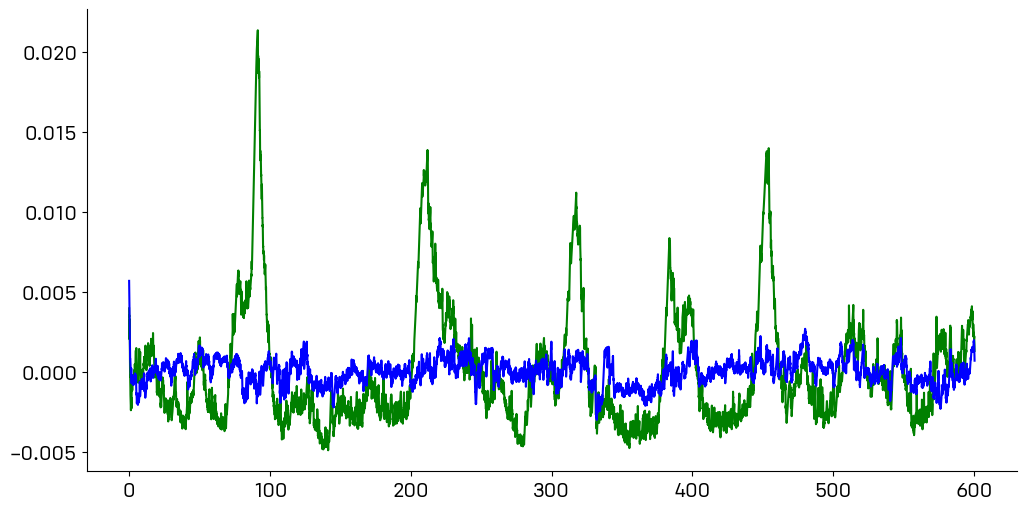

In [77]:
##PHOTOBLEACHING FREE PLOT
gcamp_detrended = gcamp_denoised - gcamp_expfit
iso_detrended = iso_denoised - iso_expfit
rcamp_detrended = rcamp_denoised - rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_detrended, color='g')
plt.plot(time, iso_detrended, color='b')



(0.0, 5.0)

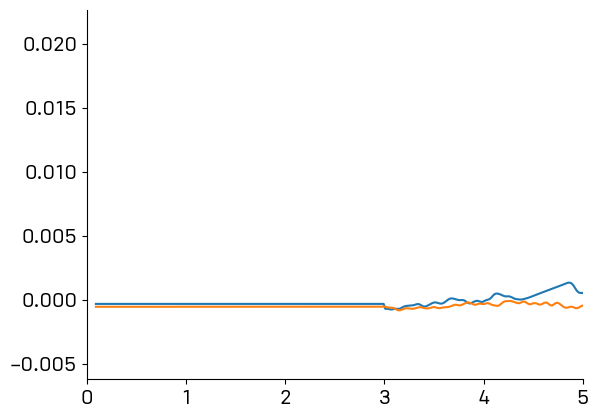

In [78]:
##WHEN TOO MUCH SIGNAL, just take out the first 3 seconds to not fuck up dff
# Find indices for the 3rd second (from 2 to 3 seconds)
indices_3_sec = (time >= 3) & (time < 4)

# Calculate the average values in the 3rd second
gcamp_3_sec_avg = np.mean(gcamp_detrended[indices_3_sec])
iso_3_sec_avg = np.mean(iso_detrended[indices_3_sec])
rcamp_3_sec_avg = np.mean(rcamp_detrended[indices_3_sec])

# Find the indices for the first 2 seconds
indices_2_sec = time < 3

# Set the first 2 seconds to the 3-second average value
gcamp_detrended[indices_2_sec] = gcamp_3_sec_avg
iso_detrended[indices_2_sec] = iso_3_sec_avg
rcamp_detrended[indices_2_sec] = rcamp_3_sec_avg

# Plot results

plt.plot(time, gcamp_detrended)
plt.plot(time, iso_detrended)
plt.xlim(0,5)



Slope    : 1.035
R-squared: 0.050


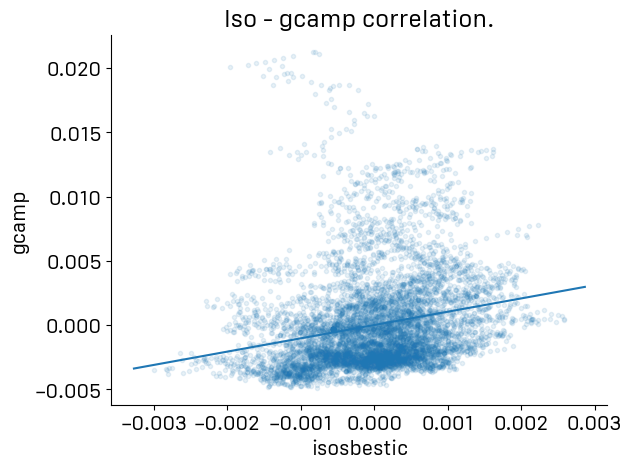

In [79]:
##REMOVING MOVEMENT ARTIFACTS 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=gcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], gcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('gcamp')
plt.title('Iso - gcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


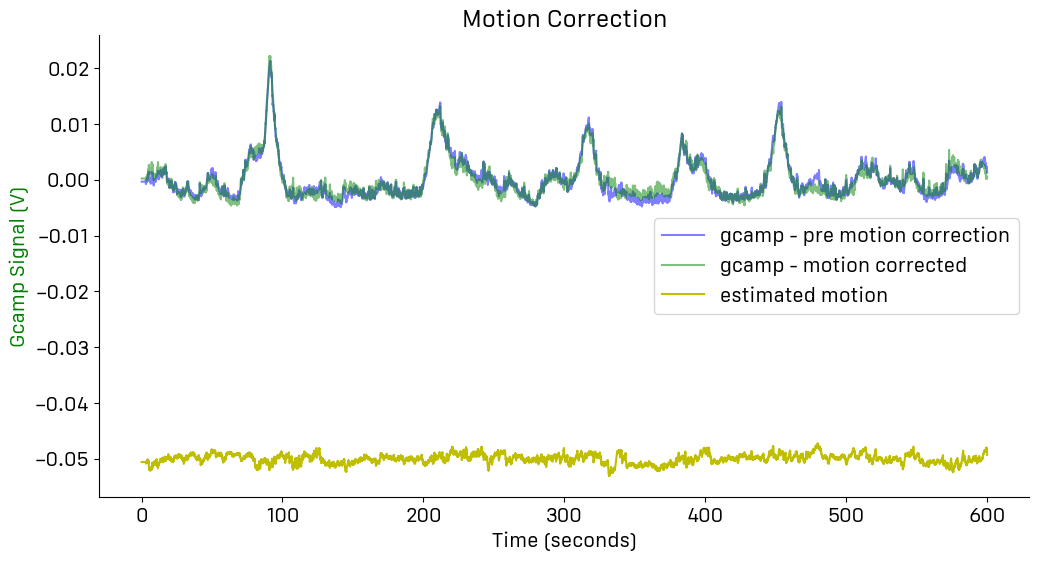

In [80]:
##SUBSTRACTING ESTIMATED MOTION 

gcamp_est_motion = intercept + slope * iso_detrended
gcamp_corrected = gcamp_detrended - gcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, gcamp_detrended, 'b' , label='gcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, gcamp_corrected, 'g', label='gcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, gcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Gcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

#ax1.set_xlim(0, 460)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

Slope    : 0.000
R-squared: 0.000


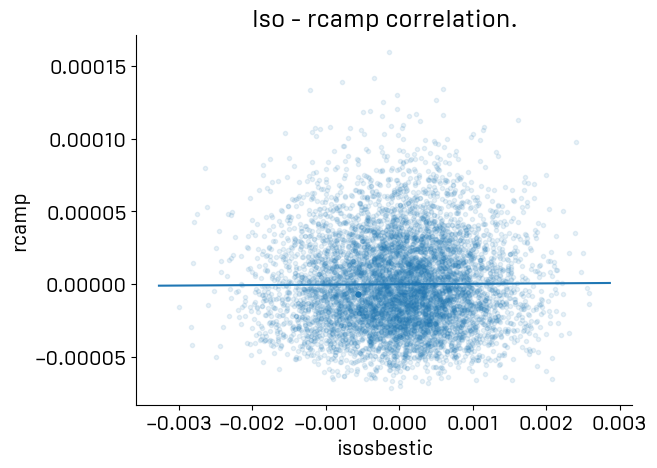

In [81]:
##REMOVING MOVEMENT ARTIFACTS RCAMP 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=rcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], rcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('rcamp')
plt.title('Iso - rcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


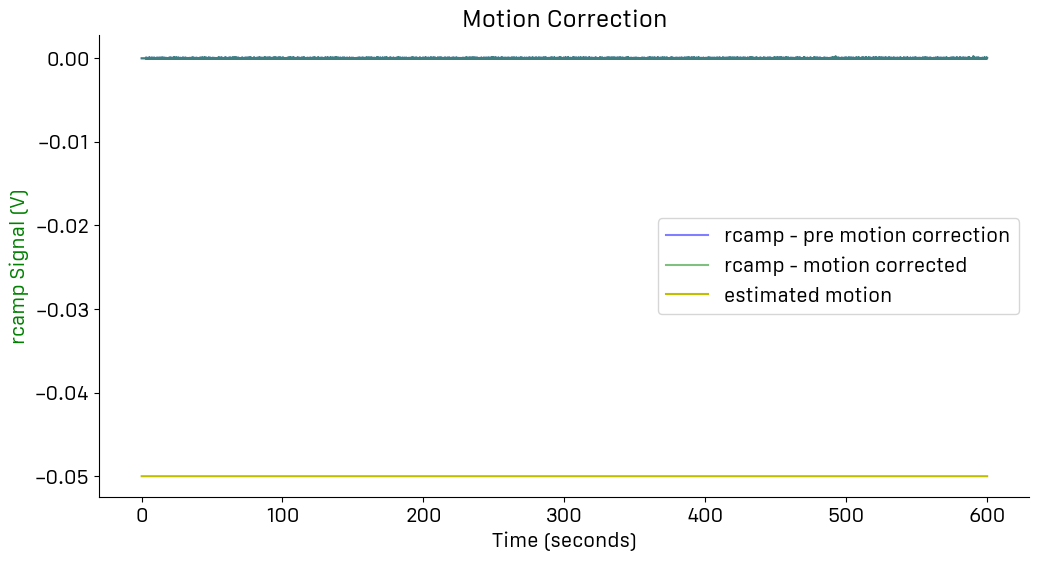

In [82]:
##SUBSTRACTING ESTIMATED MOTION RCAMP 

rcamp_est_motion = intercept + slope * iso_detrended
rcamp_corrected = rcamp_detrended - rcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, rcamp_detrended, 'b' , label='rcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, rcamp_corrected, 'g', label='rcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, rcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('rcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

# ax1.set_xlim(110, 180)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

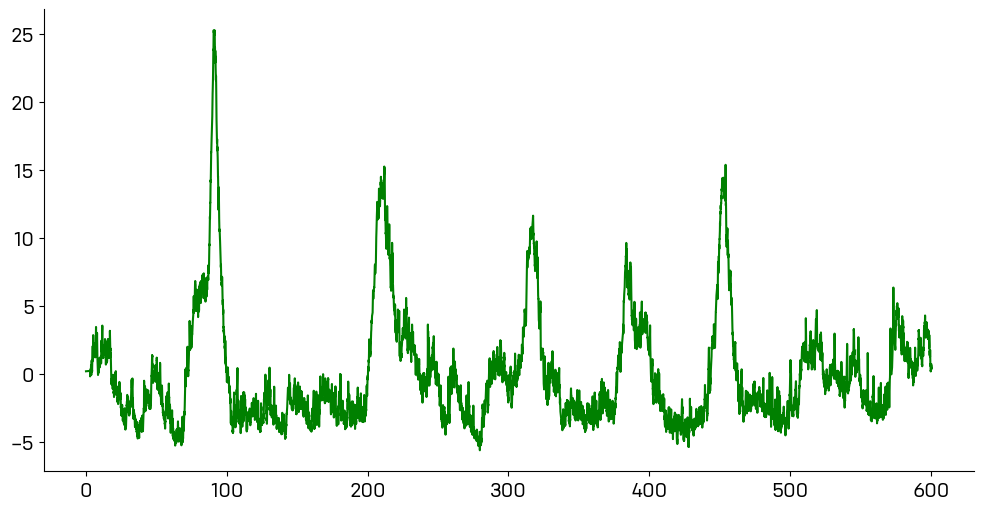

In [83]:
### NORMALIZATION : DF/F
dffg=100*gcamp_corrected/gcamp_expfit
dffr=100*rcamp_corrected/rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, dffg, color='g')
#plt.plot(time, dffr, color='r')
# plt.plot(time, rcamp_est_motion, color='b')
# plt.xlim(250, 360)
#ax1.set_ylim(-3, 3)

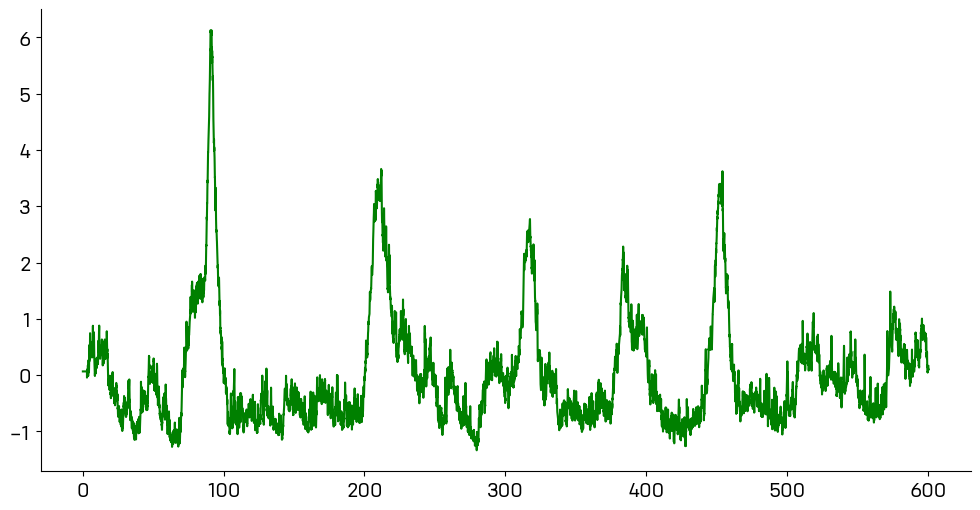

In [84]:
## Normalization : Z-Scoring 
zscoreg = (gcamp_corrected-np.mean(gcamp_corrected))/np.std(gcamp_corrected)
zscorer = (rcamp_corrected-np.mean(rcamp_corrected))/np.std(rcamp_corrected)

plt.figure(figsize=(12, 6))
plt.plot(time, zscoreg, color='g')
# plt.plot(time, zscorer, color='r')


#plt.xlim(450, 460)
#ax1.set_ylim(-3, 3);

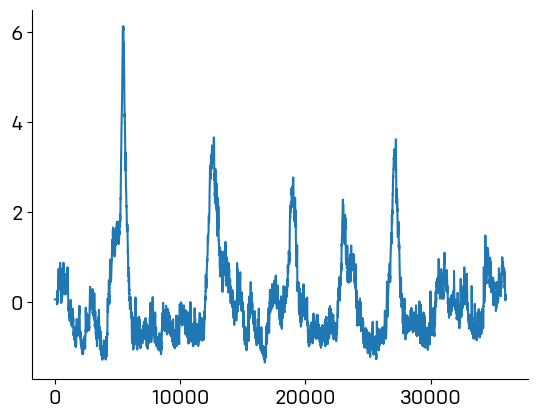

In [85]:
## SMOOTHING
from scipy.signal import savgol_filter


polyorder = 2  # Polynomial order
window_length = 181  # Window length: must be an odd number

# Apply the filter
zscore = savgol_filter(zscoreg, window_length, polyorder)

plt.plot(zscoreg)

In [86]:
###Convert preprocessed traces as df for easier manipulation

fp_df = pd.DataFrame({'Time': time, 'Zscoreg': zscoreg, 'Zscorer' : zscorer})
fp_df

,Time,Zscoreg,Zscorer
0,0.091051,0.065753,-0.204320
1,0.107724,0.065753,-0.204320
2,0.124396,0.065753,-0.204320
3,0.141068,0.065753,-0.204320
4,0.157741,0.065753,-0.204320
...,...,...,...
35997,600.247089,0.105625,-0.055755
35998,600.263762,0.091840,0.248920
35999,600.280434,0.091239,0.101875
36000,600.297106,0.115952,0.091888


In [87]:
ampos = ampos.dropna(subset=['Centre position X', 'Centre position Y'])

#Create time bins and put them into main df
time_bins = ampos['Time (s)'].values  # Use ampos time as bin edges
time_bins = np.append(time_bins, time_bins[-1] + (time_bins[-1] - time_bins[-2]))  # Add an extra bin edge to cover all data
fp_df['Time_bin'] = pd.cut(fp_df['Time'], bins=time_bins, labels=time_bins[:-1], include_lowest=True)

# Average Zscore for each bin
binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()
binned_zscoreg.rename(columns={'Time_bin': 'Time (s)'}, inplace=True)

binned_zscoreg['Zscoreg'] = (binned_zscoreg['Zscoreg'] - binned_zscoreg['Zscoreg'].min()) / (binned_zscoreg['Zscoreg'].max() - binned_zscoreg['Zscoreg'].min())
ampos2 = ampos.merge(binned_zscoreg, on='Time (s)', how='left')
np.max(ampos2['Zscoreg'])
print(ampos2)

     Time (s)  Centre position X  Centre position Y   Zscoreg
0       0.309              327.0              226.0  0.187029
1       0.421              328.0              225.0  0.187029
2       0.549              327.0              225.0  0.187029
3       0.676              324.0              225.0  0.187029
4       0.821              325.0              226.0  0.187029
...       ...                ...                ...       ...
4531  599.443              299.0              368.0  0.205385
4532  599.587              300.0              369.0  0.198129
4533  599.715              300.0              369.0  0.189397
4534  599.843              299.0              369.0  0.186683
4535  599.987              298.0              368.0  0.194977

[4536 rows x 4 columns]


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_98894/1764466804.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_zscoreg = fp_df.groupby('Time_bin')['Zscoreg'].mean().reset_index()


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_98894/1609631257.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()


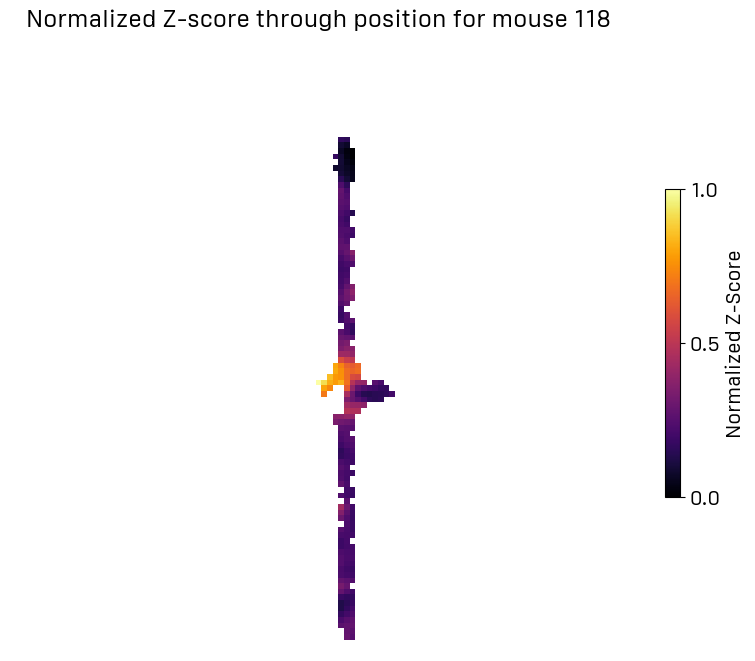

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import convolve

# Create a copy to preserve the original dataset
ampos2 = ampos.copy()

# Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
ampos2 = ampos2.dropna(subset=['Centre position X', 'Centre position Y'])

# Define 1 cm bins for spatial positions
bin_size = 5  # cm
x_bins = np.arange(0, 550, bin_size)
y_bins = np.arange(0, 550, bin_size)

# Assign data to spatial bins
ampos2['X_bin'] = pd.cut(ampos2['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
ampos2['Y_bin'] = pd.cut(ampos2['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# Merge the Zscoreg data back into ampos2
ampos2 = ampos2.merge(binned_zscoreg, on='Time (s)', how='left')

# Group by spatial bins and compute the mean Zscoreg
spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# Convert bins to numeric for heatmap plotting
spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# Pivot the table to create a 2D array for the heatmap
heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# Fill missing values with NaN instead of 0
heatmap_data = heatmap_data.fillna(np.nan)

# Create a quasi-Gaussian kernel for 5×5 bins
kernel_size = 5
sigma = 1.0
x = np.linspace(-2, 2, kernel_size)
y = np.linspace(-2, 2, kernel_size)
x, y = np.meshgrid(x, y)
kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
kernel /= np.sum(kernel)  # Normalize the kernel

# Apply the kernel to smooth the heatmap
masked_data = np.nan_to_num(heatmap_data, nan=0)
mask = ~np.isnan(heatmap_data)

# Convolve with the kernel
smoothed_data = convolve(masked_data, kernel, mode='constant', cval=0.0)
smoothed_mask = convolve(mask.astype(float), kernel, mode='constant', cval=0.0)
smoothed_data /= np.maximum(smoothed_mask, 1e-10)  # Avoid division by zero
smoothed_data[~mask] = np.nan  # Restore NaN values

# Normalize smoothed data
smoothed_data = (smoothed_data - np.nanmin(smoothed_data)) / (np.nanmax(smoothed_data) - np.nanmin(smoothed_data))

# Plot the smoothed heatmap
plt.figure(figsize=(10, 8))
plt.imshow(smoothed_data, cmap='inferno', extent=[0, 550, 0, 550], origin='lower', interpolation='none', zorder=3)

# Customize plot
cbar = plt.colorbar(label='Normalized Z-Score', shrink=0.5, fraction=0.05)
cbar.set_ticks([0, 0.5, 1])
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')

plt.xlim(0, 550)  # Set limits
plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

#plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/smoothed_heatmap{mouse_id}.pdf', format='pdf')
plt.show()


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_98894/1867426466.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()


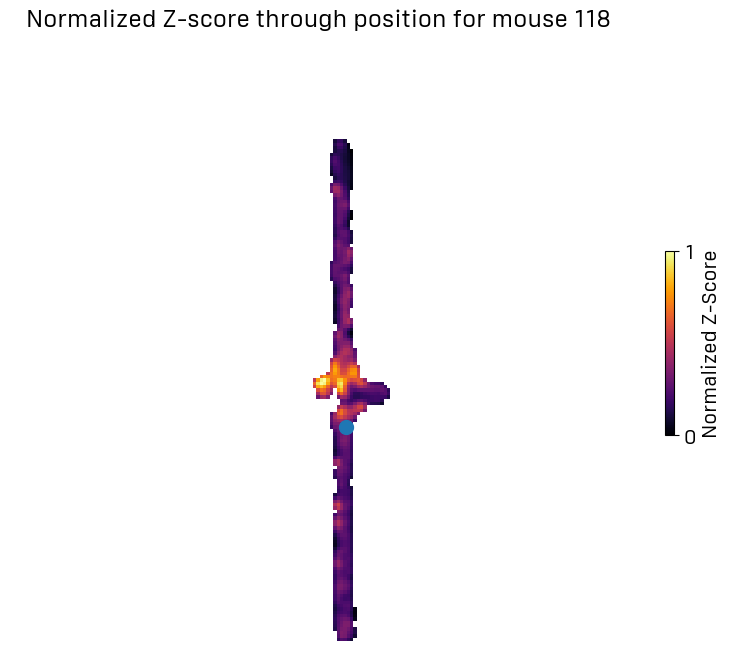

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.ndimage import gaussian_filter

# Create a copy to preserve the original dataset
ampos2 = ampos.copy()

# Drop rows with NaN values in 'Centre position X' and 'Centre position Y'
ampos2 = ampos2.dropna(subset=['Centre position X', 'Centre position Y'])

# Define 1 cm bins for spatial positions
bin_size = 3  # cm
x_bins = np.arange(0, 550, bin_size)
y_bins = np.arange(0, 550, bin_size)

# Assign data to spatial bins
ampos2['X_bin'] = pd.cut(ampos2['Centre position X'], bins=x_bins, labels=x_bins[:-1], include_lowest=True)
ampos2['Y_bin'] = pd.cut(ampos2['Centre position Y'], bins=y_bins, labels=y_bins[:-1], include_lowest=True)

# Merge the Zscoreg data back into ampos2
ampos2 = ampos2.merge(binned_zscoreg, on='Time (s)', how='left')

# Group by spatial bins and compute the mean Zscoreg
spatial_avg = ampos2.groupby(['X_bin', 'Y_bin'])['Zscoreg'].mean().reset_index()

# Convert bins to numeric for heatmap plotting
spatial_avg['X_bin'] = spatial_avg['X_bin'].astype(float)
spatial_avg['Y_bin'] = spatial_avg['Y_bin'].astype(float)

# Pivot the table to create a 2D array for the heatmap
heatmap_data = spatial_avg.pivot(index='Y_bin', columns='X_bin', values='Zscoreg')

# Fill missing values with NaN instead of 0
heatmap_data = heatmap_data.fillna(np.nan)

# Create Gaussian Kernel and apply smoothing
stddev = 0.3  # Standard deviation for the Gaussian kernel
kernel = Gaussian2DKernel(stddev)
smoothed_data = convolve(heatmap_data, kernel, boundary='extend')

# Mask NaN values
masked_data = np.nan_to_num(smoothed_data, nan=0)
mask = ~np.isnan(smoothed_data)

# Apply Gaussian filter only to the valid (non-NaN) data
smoothed_data = gaussian_filter(masked_data, sigma=1)
smoothed_data[~mask] = np.nan  # Restore NaN values


smoothed_data = (smoothed_data - np.nanmin(smoothed_data)) / (np.nanmax(smoothed_data) - np.nanmin(smoothed_data))

# Plot the smoothed heatmap

print(smoothed_data)

plt.figure(figsize=(10, 8))
plt.imshow(smoothed_data, cmap='inferno', extent=[0, 550, 0, 550], origin='lower', interpolation='none', zorder=3)

# Customize plot
cbar=plt.colorbar(label='Normalized Z-Score', shrink=0.3, fraction=0.05)
cbar.set_ticks([0, 1])
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')

plt.xlim(0, 550) # Set background color to black
plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.scatter(300,200, s=100, zorder=12)

# plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/figures/smoothed_heatmap{mouse_id}.pdf', format='pdf')
plt.show()

In [90]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import numpy as np

# # Parameters for the cross
# cross_size = 420  # Size of the cross in mm
# center_x = 295    # Center position X
# center_y = 235    # Center position Y

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xlim(0, 550)
# ax.set_ylim(0, 550)
# ax.set_aspect('equal', adjustable='box')
# ax.axis('off')  # Turn off axis visibility

# # Add the cross to the plot
# ax.plot(
#     [center_x - cross_size / 2, center_x + cross_size / 2], 
#     [center_y, center_y], color='black', lw=22, zorder=1)
# ax.plot(
#     [center_x, center_x], 
#     [center_y - cross_size / 2, center_y + cross_size / 2], 
#     color='black', lw=25, zorder=1)
# ax.plot(
#     [center_x - cross_size / 2, center_x + cross_size / 2], 
#     [center_y, center_y], color='white', lw=21, zorder=2)
# ax.plot(
#     [center_x, center_x], 
#     [center_y - cross_size / 2, center_y + cross_size / 2], 
#     color='white', lw=21, zorder=2)

# # Initialize scatter plot
# scatter = ax.scatter([], [], c=[], cmap='inferno', alpha=1, zorder=3,s=100)

# # Colorbar
# cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
# cbar.set_label('Normalized Z-Score')

# # Animation update function
# def update(frame):
#     # Plot the scatter point for the current frame
#     scatter.set_offsets([[ampos2.iloc[frame]['Centre position X'], ampos2.iloc[frame]['Centre position Y']]])
#     scatter.set_array(np.array([ampos2.iloc[frame]['Zscoreg']]))
#     return scatter,

# # Create the animation
# ani = animation.FuncAnimation(
#     fig, update, frames=len(ampos2), interval=300, blit=True)  # interval in ms

# # Save animation as video
# ani.save('mouse_position_zscore1035.gif', writer='pillow', fps=60)
# plt.show()


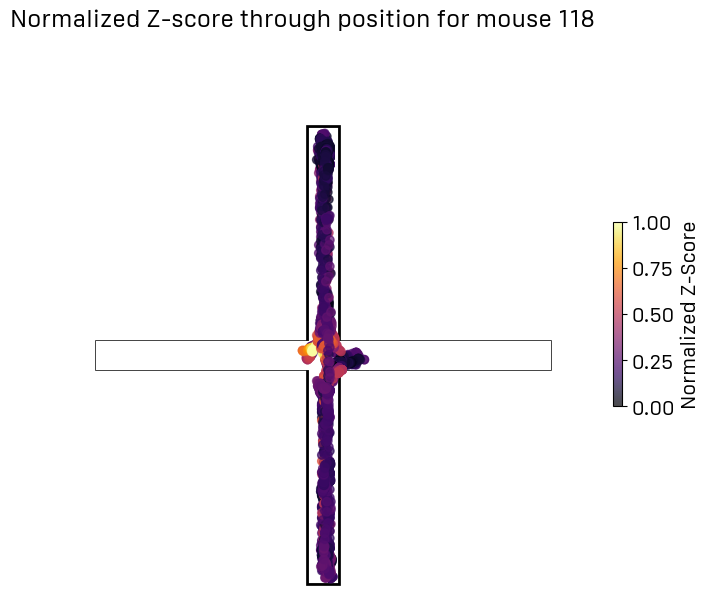

In [91]:
# plot the shit
plt.figure(figsize=(8, 8))

# Plot the scatter plot first
scatter = plt.scatter(
    ampos2['Centre position X'], 
    ampos2['Centre position Y'], 
    c=ampos2['Zscoreg'], 
    cmap='inferno',
    alpha=0.7,
    zorder=3)

# Now, plot the cross in the background by drawing after the scatter
cross_size = 420  # Size of the cross in mm
center_x = 295    # Center position X
center_y = 235   # Center position Y

# Add the cross in the background (horizontal and vertical lines)
plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], [center_y, center_y], color='black', lw=22)  # horizontal line
plt.plot([center_x, center_x], [center_y - cross_size / 2, center_y + cross_size / 2], color='black', lw=25)  # vertical line
plt.plot([center_x - cross_size / 2, center_x + cross_size / 2], 
         [center_y, center_y], color='white', lw=21, zorder=2)
plt.plot([center_x, center_x], 
         [center_y - cross_size / 2, center_y + cross_size / 2], 
         color='white', lw=21, zorder=2)

plt.colorbar(scatter, label='Normalized Z-Score', shrink=0.3, fraction=0.05)
plt.xlabel('Centre Position X (mm)')
plt.ylabel('Centre Position Y (mm)')
plt.title(f'Normalized Z-score through position for mouse {mouse_id}')
plt.xlim(0, 550) # Set background color to black
plt.ylim(0, 550)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

In [92]:
#GET EVENTS FROM ANYMAZE DF

# Initialize a dictionary to store events for each behavior
all_events = {col: {'start': [], 'end': []} for col in TTL_an.columns if col != 'Time (s)'}

# Function to extract start and end events for each behavior
def extract_events(TTL_an):
    for col in all_events.keys():
        sound_on = False
        start_time = None  # Initialize start_time
        
        for i in range(len(TTL_an)):
            if TTL_an[col].iloc[i] == 1:
                if not sound_on:  # Event starts
                    start_time = TTL_an['Time (s)'].iloc[i]
                    sound_on = True
            elif TTL_an[col].iloc[i] == 0:
                if sound_on:  # Event stops
                    end_time = TTL_an['Time (s)'].iloc[i]
                    all_events[col]['start'].append(start_time)
                    all_events[col]['end'].append(end_time)
                    sound_on = False

        # Handle the case where the signal ends with 1
        if sound_on:
            end_time = 600  # WORKS ONLY WITH THIS CONFIGURATION
            all_events[col]['start'].append(start_time)
            all_events[col]['end'].append(end_time)

# Run the function
extract_events(TTL_an)


# Convert each behavior's event data to DataFrames
df_events = {col: pd.DataFrame(data) for col, data in all_events.items()}

# Print each DataFrame for each behavior
for behavior, df in df_events.items():
    print(f"Events for {behavior}:")
    print(df)
    print("\n")

# Output the main events dictionary if needed
#print(df_events.items)


Events for Freezing:
      start      end
0     2.644    4.884
1    26.773   28.180
2    44.948   46.484
3    65.972   69.620
4   259.908  260.980
5   267.348  269.108
6   462.852  464.452
7   523.379  526.148
8   526.883  528.115
9   529.907  530.979
10  532.787  534.211
11  537.507  538.948
12  554.644  558.275
13  560.515  562.547
14  563.379  565.043
15  566.676  568.307
16  572.243  574.211


Events for In Open Arms:
    start     end
0   0.000   8.373
1   8.421   8.549
2  11.908  12.116
3  17.780  17.973
4  21.348  22.308
5  23.845  29.413
6  86.484  87.940
7  88.020  89.652


Events for In Closed Arms:
      start      end
0    10.580   10.708
1    71.220   84.548
2    84.644   85.908
3    92.980   93.140
4    93.444  207.140
5   209.172  209.220
6   209.444  209.476
7   209.572  209.620
8   209.716  209.748
9   209.940  213.780
10  214.772  223.044
11  224.772  311.540
12  315.220  315.380
13  315.412  317.572
14  317.972  382.308
15  382.820  398.308
16  398.676  447.716
17  4

In [93]:
# Add behavior columns to the main DataFrame
for behavior, df in df_events.items():
    # Initialize the behavior column with zeros
    fp_df[behavior] = 0
    
    # Iterate through each start and end time for the behavior
    for start, end in zip(df['start'], df['end']):
        # Set the behavior column to 1 for rows within the start-end interval
        fp_df.loc[(fp_df['Time'] >= start) & (fp_df['Time'] <= end), behavior] = 1

fp_df = fp_df.drop(columns=['Time_bin'])

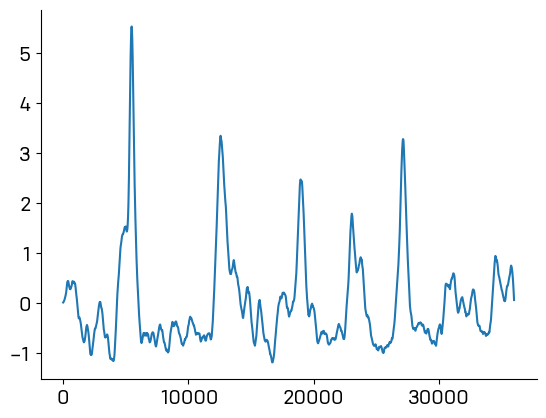

In [94]:
## SMOOTHING extreme smoothing for whole trace representative


polyorder = 2  # Polynomial order
window_length = 481  # Window length: must be an odd number

# Apply the filter
fp_df['Zscoreg'] = savgol_filter(fp_df['Zscoreg'], window_length, polyorder)

plt.plot(fp_df['Zscoreg'])

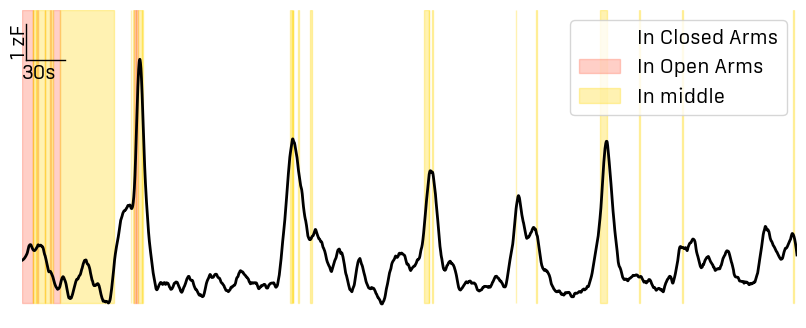

In [95]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 4))

# Plot Zscoreg through Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], color='black', linewidth=2)

# Define colors for events
behavior_columns = ['In Closed Arms', 'In Open Arms', 'In middle']
colors = ['none', 'tomato', 'gold']  # Use a colormap for unique colors

# Add shaded regions for each behavior
for color, behavior in zip(colors, behavior_columns):
    # Find time intervals where the behavior occurs
    starts = fp_df.loc[fp_df[behavior].diff() == 1, 'Time']
    ends = fp_df.loc[fp_df[behavior].diff() == -1, 'Time']
    
    # Handle case where behavior starts at the first row
    if not fp_df.empty and fp_df[behavior].iloc[0] == 1:
        starts = pd.concat([pd.Series(fp_df['Time'].iloc[0]), starts])
    # Handle case where behavior ends at the last row
    if not fp_df.empty and fp_df[behavior].iloc[-1] == 1:
        ends = pd.concat([ends, pd.Series(fp_df['Time'].iloc[-1])])
    
    # Add shaded regions with the assigned color
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, alpha=0.3, label=behavior, color=color, zorder=0, ymin=0.05, ymax=1.0)

# Customize the plot

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
scale_y_pos = y_max - (y_max - y_min) * 0.05  # Position near the top of the plot

plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
plt.text(scale_x_pos - 5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

plt.plot([scale_x_pos, scale_x_pos + 30], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
plt.text(scale_x_pos + 10, scale_y_pos - 0.1, '30s', ha='center', va='top')

#drop the y axis
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)
#Create one legend entry per event
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.xlim(0,600)
#plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/figures/fullrecording{mouse_id}.pdf', format='pdf')
plt.show()

In [96]:
#add mouse ID, sex and day of experiment(if needed)

fp_df['ID']=mouse_id
fp_df['sex']=sex
fp_df

,Time,Zscoreg,Zscorer,Freezing,In Open Arms,In Closed Arms,In middle,ID,sex
0,0.091051,0.017173,-0.204320,0,1,0,0,118,M
1,0.107724,0.017437,-0.204320,0,1,0,0,118,M
2,0.124396,0.017707,-0.204320,0,1,0,0,118,M
3,0.141068,0.017981,-0.204320,0,1,0,0,118,M
4,0.157741,0.018259,-0.204320,0,1,0,0,118,M
...,...,...,...,...,...,...,...,...,...
35997,600.247089,0.088446,-0.055755,0,0,0,0,118,M
35998,600.263762,0.082869,0.248920,0,0,0,0,118,M
35999,600.280434,0.077269,0.101875,0,0,0,0,118,M
36000,600.297106,0.071646,0.091888,0,0,0,0,118,M


In [97]:
# # saving the processed df with timestamps and zscoreeees 

# new_filename = f'{mouse_id}_{sex}_preprocessed.csv'  
# save_folder='/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed'
# save_path = os.path.join(save_folder, new_filename)

# fp_df.to_csv(save_path, index=False)